#This notebook train, validate and test extractive PreSumm models

first we need to link google Drive

If the preprocessing was done in a local machine it is necessary to upload the bert_data directory to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


code made based in https://github.com/nlpyang/PreSumm and https://www.kaggle.com/areomoon/text-summarization-with-presumm-finetuning

For more information of the commands go to https://github.com/nlpyang/PreSumm

# Folder structure

root directory:
- PreSumm-master: root directory of PreSumm
- Dataset1:
    - bert_data 
        * train
        * val
        * test
    - temp: folder for temporal files
    - logs: folder to store logs (they are also printed as output when running the commands)
    - models: Where the models (checkpoints) will be stored
        * validation_cand: Where the predictions will be saved
        * test_results: Where the predictions of the test are saved
    - finetunned: same as models but using the pretrained model
        * validation_cand: Where the predictions will be saved
        * test_results: Where the predictions of the test are saved


<br>
Dataset 3 is the same, the only difference for dataset 2 is that the folder finetunned is named pretrained, the pretrained model can be found [here](https://github.com/nlpyang/PreSumm) it is named: CNN/DM BertExt   

# Setup 
Install the required package from **requirements.txt** in presummy folder

In [ ]:
cd '/content/drive/My Drive/tfm'

In [ ]:
!pip install -r ./PreSumm-master/requirements.txt

In [ ]:
!pip install rouge

# Dataset 1

## Train

In [ ]:
import os
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src/')

In [ ]:
!python train.py -task ext -mode train -bert_data_path '/content/drive/My Drive/tfm/dataset1/bert_data/train/news' -ext_dropout 0.1 -model_path '/content/drive/My Drive/tfm/dataset1/models' -lr 2e-3 -visible_gpus 0 -report_every 50 -save_checkpoint_steps 2000 -batch_size 3000 -train_steps 36000 -accum_count 2 -log_file '/content/drive/My Drive/tfm/dataset1/logs/ext_bert_news' -use_interval true -warmup_steps 4000 -max_pos 512 -temp_dir '/content/drive/My Drive/tfm/dataset1/temp'
                                                                                                                                                                                                                                                                                                     # batch size for news 1500 for cnn 3000   pfr cnn doble steps_train and save_checkpoint                

## Getting the summaries for validation 

In [ ]:
import os
import time
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src')

for i in range(2000,28000,2000):
    
    print(i)
    !date
    start = time.time()
    code =  "python train.py -task ext -mode test -model_path '/content/drive/My Drive/tfm/dataset1/models/validation_cand/path' -test_from '/content/drive/My Drive/tfm/dataset1/models/model_step_"+str(i)+".pt' -batch_size 100 -test_batch_size 100 -bert_data_path '/content/drive/My Drive/tfm/dataset1/bert_data/val/news' -temp_dir '/content/drive/My Drive/tfm/dataset1/temp' -log_file '/content/drive/My Drive/tfm/dataset1/logs/validation' -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 200 -alpha 0.82 -min_length 10 -result_path '/content/drive/My Drive/tfm/dataset1/models/validation_cand/'"
    os.system(code)
    print(time.time()-start)




In [ ]:
from google.colab import drive
drive.flush_and_unmount()

## Calculating Rogue scores for validation



In [ ]:
import os
from rouge import Rouge

rouge = Rouge()
os.chdir('/content/drive/My Drive/tfm/dataset1/models/validation_cand')
scores_1 = []
scores_2 = []
scores_l = []
scores_sum = []
count_candidate=0
rouge = Rouge()
for j in range(2000,28001,2000):
    print(j)
    gold = './_step'+str(j)+'.gold'
    candidate = './_step'+str(j)+'.candidate'
    with open(gold,'r') as s:
        summary = s.readlines()

    with open(candidate,'r') as s:
        cand = s.readlines()

    
    rouge_1= 0
    rouge_2= 0
    rouge_l= 0
    for i in range(len(summary)):
        count_candidate+=len(cand[i])
        scores = rouge.get_scores(cand[i],summary[i])
        rouge_1+=float(scores[0]['rouge-1']['f'])
        rouge_2+=float(scores[0]['rouge-2']['f'])
        rouge_l+=float(scores[0]['rouge-l']['f'])
        
    scores_1.append(rouge_1/len(summary))
    scores_2.append(rouge_2/len(summary))
    scores_l.append(rouge_l/len(summary))
    scores_sum.append(rouge_1/len(summary)+ rouge_2/len(summary)+rouge_l/len(summary))



In [ ]:
print("Biggest rouge-1 score: ",scores_1.index(max(scores_1)))
print("Biggest rouge-2 score: ",scores_2.index(max(scores_2)))
print("Biggest rouge-l score: ",scores_l.index(max(scores_l)))
print("Biggest sum rouge scores: ",scores_sum.index(max(scores_sum)))

Biggest rouge-1 score:  1
Biggest rouge-2 score:  1
Biggest rouge-l score:  1
Biggest sum rouge scores:  1


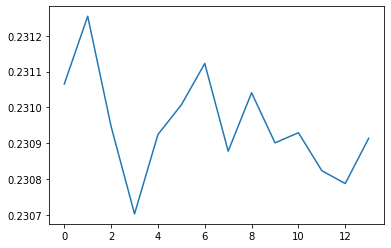

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(scores_1,label = 'rouge-1')

In [ ]:
print("Biggest rouge-1 score: ",scores_1[1])
print("Biggest rouge-2 score: ",scores_2[1])
print("Biggest rouge-l score: ",scores_l[1])


Biggest rouge-1 score:  0.2312545577703695
Biggest rouge-2 score:  0.09617585162587242
Biggest rouge-l score:  0.2372267581131973


## Test

In [ ]:
import os
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src')
   
!python train.py -task ext -mode test -model_path '/content/drive/My Drive/tfm/dataset1/models/test/' -test_from '/content/drive/My Drive/tfm/dataset1/models/model_step_4000.pt' -batch_size 100 -test_batch_size 100 -bert_data_path '/content/drive/My Drive/tfm/dataset1/bert_data/test/news' -temp_dir '/content/drive/My Drive/tfm/dataset1/temp' -log_file '/content/drive/My Drive/tfm/dataset1/logs/test_kaggle' -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 200 -alpha 0.82 -min_length 10 -result_path '/content/drive/My Drive/tfm/dataset1/models/test_results'



In [ ]:
import os
from rouge import Rouge
import numpy as np


rouge = Rouge()
os.chdir('/content/drive/My Drive/tfm/dataset1/models/test_results')
scores_1 = []
scores_2 = []
scores_l = []
hist_1 = []
hist_2 = []
hist_l = []

rouge = Rouge()
for j in [4000]:
    gold = './test_results_step'+str(j)+'.gold'
    candidate = './test_results_step'+str(j)+'.candidate'
    with open(gold,'r') as s:
        summary = s.readlines()

    with open(candidate,'r') as s:
        cand = s.readlines()

    rouge_1= 0
    rouge_2= 0
    rouge_l= 0
    for i in range(len(summary)):
       
        scores = rouge.get_scores(cand[i],summary[i])
        hist_1.append(float(scores[0]['rouge-1']['f']))
        hist_2.append(float(scores[0]['rouge-2']['f']))
        hist_l.append(float(scores[0]['rouge-l']['f']))

        rouge_1+=float(scores[0]['rouge-1']['f'])
        rouge_2+=float(scores[0]['rouge-2']['f'])
        rouge_l+=float(scores[0]['rouge-l']['f'])
    
    scores_1.append(rouge_1/len(summary))
    scores_2.append(rouge_2/len(summary))
    scores_l.append(rouge_l/len(summary))

def get_conf_int(hist,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(hist, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(hist, p))
    return lower,upper


alpha = 0.9
lower1,upper1 = get_conf_int(hist_1,alpha)
lower2,upper2 = get_conf_int(hist_2,alpha)
lower3,upper3 = get_conf_int(hist_l,alpha)

print('Rouge-1:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_1[0],alpha*100, lower1, upper1))
print('Rouge-2:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_2[0],alpha*100, lower2, upper2))
print('Rouge-l:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_l[0],alpha*100, lower3, upper3))
    



Rouge-1:
 	 mean: 0.2348 
 	 Confidence interval: 90 %  [0.135 , 0.357]
Rouge-2:
 	 mean: 0.1004 
 	 Confidence interval: 90 %  [0.000 , 0.220]
Rouge-l:
 	 mean: 0.2401 
 	 Confidence interval: 90 %  [0.125 , 0.372]


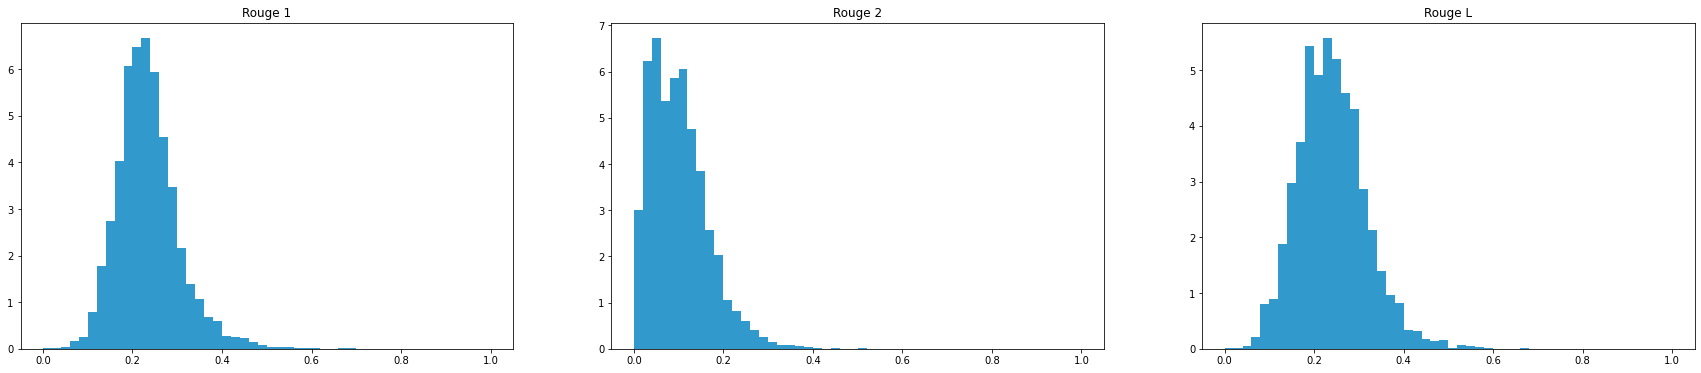

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(30,6))
ax1.set_title("Rouge 1")
ax2.set_title("Rouge 2")
ax3.set_title("Rouge L")
_ = ax1.hist(hist_1,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax2.hist(hist_2,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax3.hist(hist_l,bins=50,range=(0,1),density=True,color="#3299CC")

#  Dataset 2

## Train

In [ ]:
import os
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src/')

In [ ]:
!python train.py -task ext -mode train -bert_data_path '/content/drive/My Drive/tfm/dataset2/bert_data/train/news' -ext_dropout 0.1 -model_path '/content/drive/My Drive/tfm/dataset2/models' -lr 2e-3 -visible_gpus 0 -report_every 50 -save_checkpoint_steps 2000 -batch_size 3000 -train_steps 36000 -accum_count 2 -log_file '/content/drive/My Drive/tfm/dataset2/logs/ext_bert_news' -use_interval true -warmup_steps 4000 -max_pos 512 -temp_dir '/content/drive/My Drive/tfm/dataset2/temp'


## Getting the summaries for validation

In [ ]:
import os
import time
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src')

for i in range(2000,26001,2000):
    
    print(i)
    !date
    start = time.time()
    code =  "python train.py -task ext -mode test -model_path '/content/drive/My Drive/tfm/dataset2/models/validation_cand/path' -test_from '/content/drive/My Drive/tfm/dataset2/models/model_step_"+str(i)+".pt' -batch_size 100 -test_batch_size 100 -bert_data_path '/content/drive/My Drive/tfm/dataset2/bert_data/val/news' -temp_dir '/content/drive/My Drive/tfm/dataset2/temp' -log_file '/content/drive/My Drive/tfm/dataset1/logs/validation' -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 200 -alpha 0.82 -min_length 10 -result_path '/content/drive/My Drive/tfm/dataset2/models/validation_cand/'"
    os.system(code)
    print(time.time()-start)



In [ ]:
from google.colab import drive
drive.flush_and_unmount()

## Calculating Rogue scores for validation

In [ ]:
import os
from rouge import Rouge

rouge = Rouge()
os.chdir('/content/drive/My Drive/tfm/dataset2/models/validation_cand')
scores_1 = []
scores_2 = []
scores_l = []
scores_sum = []
count_candidate=0
rouge = Rouge()
for j in range(2000,26001,2000):
    print(j)
    gold = './_step'+str(j)+'.gold'
    candidate = './_step'+str(j)+'.candidate'
    with open(gold,'r') as s:
        summary = s.readlines()

    with open(candidate,'r') as s:
        cand = s.readlines()

    rouge_1= 0
    rouge_2= 0
    rouge_l= 0
    for i in range(len(summary)):
        count_candidate+=len(cand[i])
        scores = rouge.get_scores(cand[i],summary[i])
        rouge_1+=float(scores[0]['rouge-1']['f'])
        rouge_2+=float(scores[0]['rouge-2']['f'])
        rouge_l+=float(scores[0]['rouge-l']['f'])
        
    scores_1.append(rouge_1/len(summary))
    scores_2.append(rouge_2/len(summary))
    scores_l.append(rouge_l/len(summary))
    scores_sum.append(rouge_1/len(summary)+ rouge_2/len(summary)+rouge_l/len(summary))



In [ ]:
print("Biggest rouge-1 score: ",scores_1.index(max(scores_1)))
print("Biggest rouge-2 score: ",scores_2.index(max(scores_2)))
print("Biggest rouge-l score: ",scores_l.index(max(scores_l)))
print("Biggest sum rouge scores: ",scores_sum.index(max(scores_sum)))



Biggest rouge-1 score:  8
Biggest rouge-2 score:  8
Biggest rouge-l score:  8
Biggest sum rouge scores:  8


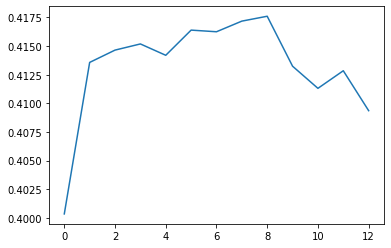

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(scores_1,label = 'rouge-1')

In [ ]:
print("Biggest rouge-1 score: ",scores_1[8])
print("Biggest rouge-2 score: ",scores_2[8])
print("Biggest rouge-l score: ",scores_l[8])


Biggest rouge-1 score:  0.41760428373510994
Biggest rouge-2 score:  0.18681683130961155
Biggest rouge-l score:  0.40314722701812955


## Test

In [ ]:
import os
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src')
   
!python train.py -task ext -mode test -model_path '/content/drive/My Drive/tfm/dataset2/models/test/' -test_from '/content/drive/My Drive/tfm/dataset2/models/model_step_18000.pt' -batch_size 100 -test_batch_size 100 -bert_data_path '/content/drive/My Drive/tfm/dataset2/bert_data/test/news' -temp_dir '/content/drive/My Drive/tfm/dataset2/temp' -log_file '/content/drive/My Drive/tfm/dataset2/logs/test_kaggle' -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 200 -alpha 0.82 -min_length 10 -result_path '/content/drive/My Drive/tfm/dataset2/models/test_results/'



In [ ]:
import os
from rouge import Rouge
import numpy as np


rouge = Rouge()
os.chdir('/content/drive/My Drive/tfm/dataset2/models/')
scores_1 = []
scores_2 = []
scores_l = []
hist_1 = []
hist_2 = []
hist_l = []

rouge = Rouge()
for j in [18000]:
    gold = './test_results_step'+str(j)+'.gold'
    candidate = './test_results_step'+str(j)+'.candidate'
    with open(gold,'r') as s:
        summary = s.readlines()

    with open(candidate,'r') as s:
        cand = s.readlines()

    rouge_1= 0
    rouge_2= 0
    rouge_l= 0
    for i in range(len(summary)):
       
        scores = rouge.get_scores(cand[i],summary[i])
        hist_1.append(float(scores[0]['rouge-1']['f']))
        hist_2.append(float(scores[0]['rouge-2']['f']))
        hist_l.append(float(scores[0]['rouge-l']['f']))

        rouge_1+=float(scores[0]['rouge-1']['f'])
        rouge_2+=float(scores[0]['rouge-2']['f'])
        rouge_l+=float(scores[0]['rouge-l']['f'])
    
    scores_1.append(rouge_1/len(summary))
    scores_2.append(rouge_2/len(summary))
    scores_l.append(rouge_l/len(summary))

def get_conf_int(hist,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(hist, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(hist, p))
    return lower,upper


alpha = 0.9
lower1,upper1 = get_conf_int(hist_1,alpha)
lower2,upper2 = get_conf_int(hist_2,alpha)
lower3,upper3 = get_conf_int(hist_l,alpha)

print('Rouge-1:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_1[0],alpha*100, lower1, upper1))
print('Rouge-2:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_2[0],alpha*100, lower2, upper2))
print('Rouge-l:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_l[0],alpha*100, lower3, upper3))
    



Rouge-1:
 	 mean: 0.4102 
 	 Confidence interval: 90 %  [0.232 , 0.602]
Rouge-2:
 	 mean: 0.1812 
 	 Confidence interval: 90 %  [0.033 , 0.400]
Rouge-l:
 	 mean: 0.3965 
 	 Confidence interval: 90 %  [0.213 , 0.607]


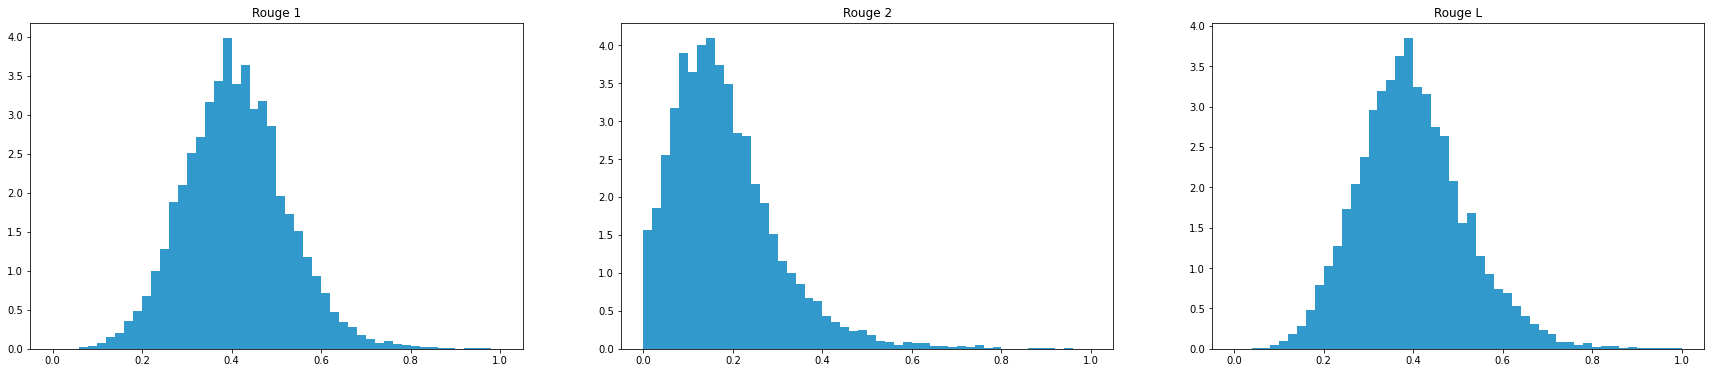

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(30,6))
ax1.set_title("Rouge 1")
ax2.set_title("Rouge 2")
ax3.set_title("Rouge L")
_ = ax1.hist(hist_1,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax2.hist(hist_2,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax3.hist(hist_l,bins=50,range=(0,1),density=True,color="#3299CC")

# Dataset 3

## Train

In [ ]:
import os
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src/')

In [ ]:
!python train.py -task ext -mode train -bert_data_path '/content/drive/My Drive/tfm/dataset3/bert_data/train/news' -ext_dropout 0.1 -model_path '/content/drive/My Drive/tfm/dataset3/models' -lr 2e-3 -visible_gpus 0 -report_every 50 -save_checkpoint_steps 1000 -batch_size 3000 -train_steps 20000 -accum_count 2 -log_file '/content/drive/My Drive/tfm/dataset3/logs/ext_bert_news' -use_interval true -warmup_steps 4000 -max_pos 512 -temp_dir '/content/drive/My Drive/tfm/dataset3/temp'


## Getting the summaries for validation

In [ ]:
import os
import time
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src')

for i in [13000,14000]:
    
    print(i)
    !date
    start = time.time()
    # python train.py -task ext -mode test -model_path '/content/drive/My Drive/tfm/PreSumm-master/models/bertsumextabs2' -test_from '/content/drive/My Drive/tfm/PreSumm-master/models/bertext_cnndm_transformer.pt' -batch_size 100 -test_batch_size 100 -bert_data_path '/content/drive/My Drive/tfm/working/test/news' -temp_dir '/content/drive/My Drive/tfm/working/temp' -log_file '/content/drive/My Drive/tfm/working/logs/extractive_bert'  -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 200 -alpha 0.82 -min_length 10 -result_path '/content/drive/My Drive/tfm/working/logs/extractive_bert'
    code =  "python train.py -task ext -mode test -model_path '/content/drive/My Drive/tfm/dataset3/models/validation_cand/path' -test_from '/content/drive/My Drive/tfm/dataset3/models/model_step_"+str(i)+".pt' -batch_size 100 -test_batch_size 100 -bert_data_path '/content/drive/My Drive/tfm/dataset3/bert_data/val/news' -temp_dir '/content/drive/My Drive/tfm/dataset3/temp' -log_file '/content/drive/My Drive/tfm/dataset3/logs/validation' -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 1000 -alpha 0.82 -min_length 10 -result_path '/content/drive/My Drive/tfm/dataset3/models/validation_cand/'"
    os.system(code)
    print(time.time()-start)




## Calculating Rogue scores for validation

In [ ]:
import os
from rouge import Rouge

rouge = Rouge()
os.chdir('/content/drive/My Drive/tfm/dataset3/models/validation_cand')
scores_1 = []
scores_2 = []
scores_l = []
scores_sum = []
count_candidate=0
rouge = Rouge()
for j in range(2000,26001,2000):
    print(j)
    gold = './_step'+str(j)+'.gold'
    candidate = './_step'+str(j)+'.candidate'
    with open(gold,'r') as s:
        summary = s.readlines()

    with open(candidate,'r') as s:
        cand = s.readlines()

    
    rouge_1= 0
    rouge_2= 0
    rouge_l= 0
    for i in range(len(summary)):
        count_candidate+=len(cand[i])
        scores = rouge.get_scores(cand[i],summary[i])
        rouge_1+=float(scores[0]['rouge-1']['f'])
        rouge_2+=float(scores[0]['rouge-2']['f'])
        rouge_l+=float(scores[0]['rouge-l']['f'])
        
    scores_1.append(rouge_1/len(summary))
    scores_2.append(rouge_2/len(summary))
    scores_l.append(rouge_l/len(summary))
    scores_sum.append(rouge_1/len(summary)+ rouge_2/len(summary)+rouge_l/len(summary))



In [ ]:
print("Biggest rouge-1 score: ",scores_1.index(max(scores_1)))
print("Biggest rouge-2 score: ",scores_2.index(max(scores_2)))
print("Biggest rouge-l score: ",scores_l.index(max(scores_l)))
print("Biggest sum rouge scores: ",scores_sum.index(max(scores_sum)))



Biggest rouge-1 score:  3
Biggest rouge-2 score:  3
Biggest rouge-l score:  3
Biggest sum rouge scores:  3


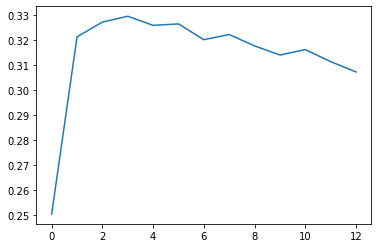

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(scores_1,label = 'rouge-1')

In [ ]:
print("Biggest rouge-1 score: ",scores_1[3])
print("Biggest rouge-2 score: ",scores_2[3])
print("Biggest rouge-l score: ",scores_l[3])


Biggest rouge-1 score:  0.3296463385802276
Biggest rouge-2 score:  0.11755868004267836
Biggest rouge-l score:  0.29056471004475004


## Test

In [ ]:
import os
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src')
   
!python train.py -task ext -mode test -model_path '/content/drive/My Drive/tfm/dataset3/models/test/' -test_from '/content/drive/My Drive/tfm/dataset3/models/model_step_8000.pt' -batch_size 3000 -test_batch_size 500 -bert_data_path '/content/drive/My Drive/tfm/dataset3/bert_data/test/news' -temp_dir '/content/drive/My Drive/tfm/dataset3/temp' -log_file '/content/drive/My Drive/tfm/dataset3/logs/test_kaggle' -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 1000 -alpha 0.1 -min_length 250 -result_path '/content/drive/My Drive/tfm/dataset3/models/test_results'



In [ ]:
import os
from rouge import Rouge
import numpy as np


rouge = Rouge()
os.chdir('/content/drive/My Drive/tfm/dataset3/models/test_results')
scores_1 = []
scores_2 = []
scores_l = []
hist_1 = []
hist_2 = []
hist_l = []

rouge = Rouge()
for j in [8000]:
    gold = './test_results_step'+str(j)+'.gold'
    candidate = './test_results_step'+str(j)+'.candidate'
    with open(gold,'r') as s:
        summary = s.readlines()
    
    with open(candidate,'r') as s:
        cand = s.readlines()

    rouge_1= 0
    rouge_2= 0
    rouge_l= 0
    for i in range(len(summary)):
       
        scores = rouge.get_scores(cand[i],summary[i])
        hist_1.append(float(scores[0]['rouge-1']['f']))
        hist_2.append(float(scores[0]['rouge-2']['f']))
        hist_l.append(float(scores[0]['rouge-l']['f']))

        rouge_1+=float(scores[0]['rouge-1']['f'])
        rouge_2+=float(scores[0]['rouge-2']['f'])
        rouge_l+=float(scores[0]['rouge-l']['f'])
    
    scores_1.append(rouge_1/len(summary))
    scores_2.append(rouge_2/len(summary))
    scores_l.append(rouge_l/len(summary))

def get_conf_int(hist,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(hist, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(hist, p))
    return lower,upper


alpha = 0.9
lower1,upper1 = get_conf_int(hist_1,alpha)
lower2,upper2 = get_conf_int(hist_2,alpha)
lower3,upper3 = get_conf_int(hist_l,alpha)

print('Rouge-1:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_1[0],alpha*100, lower1, upper1))
print('Rouge-2:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_2[0],alpha*100, lower2, upper2))
print('Rouge-l:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_l[0],alpha*100, lower3, upper3))
    



Rouge-1:
 	 mean: 0.3311 
 	 Confidence interval: 90 %  [0.197 , 0.486]
Rouge-2:
 	 mean: 0.1174 
 	 Confidence interval: 90 %  [0.023 , 0.294]
Rouge-l:
 	 mean: 0.2907 
 	 Confidence interval: 90 %  [0.160 , 0.465]


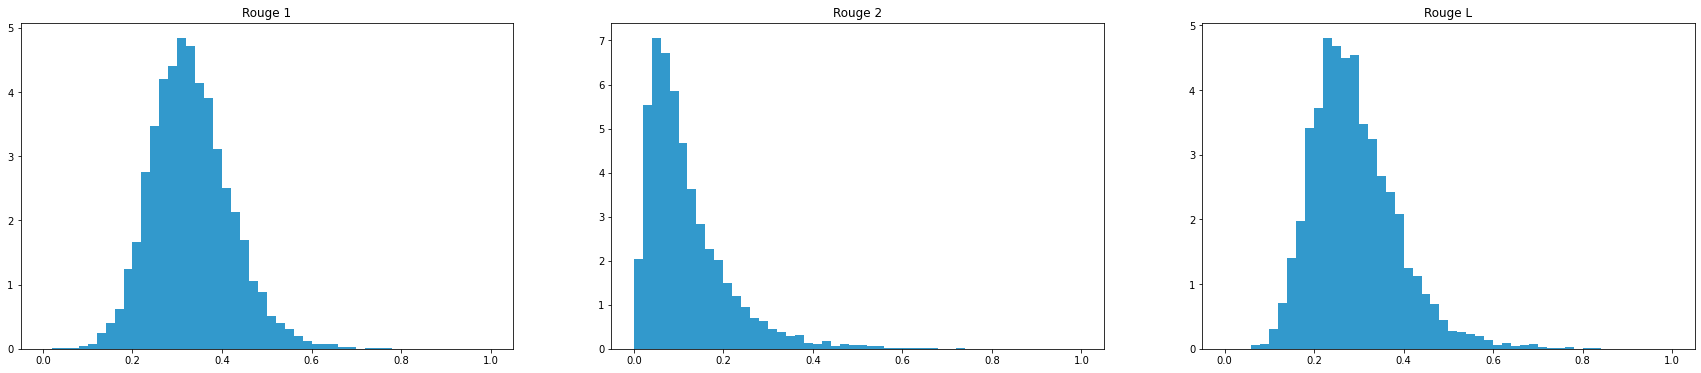

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(30,6))
ax1.set_title("Rouge 1")
ax2.set_title("Rouge 2")
ax3.set_title("Rouge L")
_ = ax1.hist(hist_1,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax2.hist(hist_2,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax3.hist(hist_l,bins=50,range=(0,1),density=True,color="#3299CC")

# Finetunned dataset 1


Using the pretrained model as a start of the training

## finetunned train

In [ ]:
import os
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src')

!python train.py -task ext -mode train -train_from '/content/drive/My Drive/tfm/dataset2/pretrained/bertext_cnndm_transformer.pt' -bert_data_path '/content/drive/My Drive/tfm/dataset1/bert_data/train/news' -ext_dropout 0.1 -model_path '/content/drive/My Drive/tfm/dataset1/finetunned' -lr 2e-3 -visible_gpus 0 -report_every 100 -save_checkpoint_steps 2000 -batch_size 3000 -train_steps 28000 -accum_count 2 -log_file '/content/drive/My Drive/tfm/dataset1/logs/finetunned' -use_interval true -warmup_steps 4000 -max_pos 512 -temp_dir '/content/drive/My Drive/tfm/dataset1/temp'


## getting val summaries

In [ ]:
import os
import time
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src')

for i in range(20000,28001,2000):
    
    print(i)
    !date
    start = time.time()
    code =  "python train.py -task ext -mode test -model_path '/content/drive/My Drive/tfm/dataset1/finetunned/validation_cand/' -test_from '/content/drive/My Drive/tfm/dataset1/finetunned/model_step_"+str(i)+".pt' -batch_size 100 -test_batch_size 100 -bert_data_path '/content/drive/My Drive/tfm/dataset1/bert_data/val/news' -temp_dir '/content/drive/My Drive/tfm/dataset1/temp' -log_file '/content/drive/My Drive/tfm/dataset1/logs/validation_finetunned' -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 200 -alpha 0.82 -min_length 10 -result_path '/content/drive/My Drive/tfm/dataset1/finetunned/validation_cand/'"
    os.system(code)
    print(time.time()-start)




## geting validtion scores

In [ ]:
import os
from rouge import Rouge

rouge = Rouge()
os.chdir('/content/drive/My Drive/tfm/dataset1/models/validation_cand')
scores_1 = []
scores_2 = []
scores_l = []
scores_sum = []
count_candidate=0
rouge = Rouge()
for j in range(20000,28001,2000):
    print(j)
    gold = './_step'+str(j)+'.gold'
    candidate = './_step'+str(j)+'.candidate'
    with open(gold,'r') as s:
        summary = s.readlines()

    with open(candidate,'r') as s:
        cand = s.readlines()

    
    rouge_1= 0
    rouge_2= 0
    rouge_l= 0
    for i in range(len(summary)):
        count_candidate+=len(cand[i])
        scores = rouge.get_scores(cand[i],summary[i])
        rouge_1+=float(scores[0]['rouge-1']['f'])
        rouge_2+=float(scores[0]['rouge-2']['f'])
        rouge_l+=float(scores[0]['rouge-l']['f'])
        
    scores_1.append(rouge_1/len(summary))
    scores_2.append(rouge_2/len(summary))
    scores_l.append(rouge_l/len(summary))
    scores_sum.append(rouge_1/len(summary)+ rouge_2/len(summary)+rouge_l/len(summary))



In [ ]:
print("Biggest rouge-1 score: ",scores_1.index(max(scores_1)))
print("Biggest rouge-2 score: ",scores_2.index(max(scores_2)))
print("Biggest rouge-l score: ",scores_l.index(max(scores_l)))
print("Biggest sum rouge scores: ",scores_sum.index(max(scores_sum)))

Biggest rouge-1 score:  1
Biggest rouge-2 score:  1
Biggest rouge-l score:  4
Biggest sum rouge scores:  4


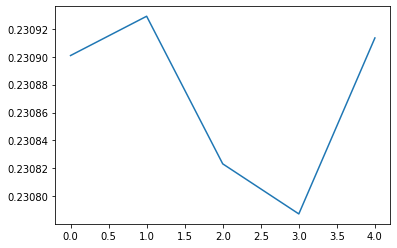

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(scores_1,label = 'rouge-1')

In [ ]:
print("Biggest rouge-1 score: ",scores_1[4])
print("Biggest rouge-2 score: ",scores_2[4])
print("Biggest rouge-l score: ",scores_l[4])


Biggest rouge-1 score:  0.23091353611184973
Biggest rouge-2 score:  0.09599680445727907
Biggest rouge-l score:  0.23687741486595543


## test

In [ ]:
import os
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src')
   
!python train.py -task ext -mode test -model_path '/content/drive/My Drive/tfm/dataset1/finetunned/' -test_from '/content/drive/My Drive/tfm/dataset1/finetunned/model_step_28000.pt' -batch_size 3000 -test_batch_size 500 -bert_data_path '/content/drive/My Drive/tfm/dataset3/bert_data/test/news' -temp_dir '/content/drive/My Drive/tfm/dataset3/temp' -log_file '/content/drive/My Drive/tfm/dataset1/logs/test_finetunned' -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 1000 -alpha 0.1 -min_length 250 -result_path '/content/drive/My Drive/tfm/dataset1/finetunned/test_results'



In [ ]:
import os
from rouge import Rouge
import numpy as np


rouge = Rouge()
os.chdir('/content/drive/My Drive/tfm/dataset1/finetunned')
scores_1 = []
scores_2 = []
scores_l = []
hist_1 = []
hist_2 = []
hist_l = []

rouge = Rouge()
for j in [28000]:
    gold = './test_results_step'+str(j)+'.gold'
    candidate = './test_results_step'+str(j)+'.candidate'
    with open(gold,'r') as s:
        summary = s.readlines()
    
    with open(candidate,'r') as s:
        cand = s.readlines()

    rouge_1= 0
    rouge_2= 0
    rouge_l= 0
    for i in range(len(summary)):
       
        scores = rouge.get_scores(cand[i],summary[i])
        hist_1.append(float(scores[0]['rouge-1']['f']))
        hist_2.append(float(scores[0]['rouge-2']['f']))
        hist_l.append(float(scores[0]['rouge-l']['f']))

        rouge_1+=float(scores[0]['rouge-1']['f'])
        rouge_2+=float(scores[0]['rouge-2']['f'])
        rouge_l+=float(scores[0]['rouge-l']['f'])
    
    scores_1.append(rouge_1/len(summary))
    scores_2.append(rouge_2/len(summary))
    scores_l.append(rouge_l/len(summary))

def get_conf_int(hist,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(hist, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(hist, p))
    return lower,upper


alpha = 0.9
lower1,upper1 = get_conf_int(hist_1,alpha)
lower2,upper2 = get_conf_int(hist_2,alpha)
lower3,upper3 = get_conf_int(hist_l,alpha)

print('Rouge-1:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_1[0],alpha*100, lower1, upper1))
print('Rouge-2:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_2[0],alpha*100, lower2, upper2))
print('Rouge-l:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_l[0],alpha*100, lower3, upper3))
    



Rouge-1:
 	 mean: 0.2546 
 	 Confidence interval: 90 %  [0.124 , 0.409]
Rouge-2:
 	 mean: 0.0781 
 	 Confidence interval: 90 %  [0.012 , 0.190]
Rouge-l:
 	 mean: 0.2417 
 	 Confidence interval: 90 %  [0.129 , 0.384]


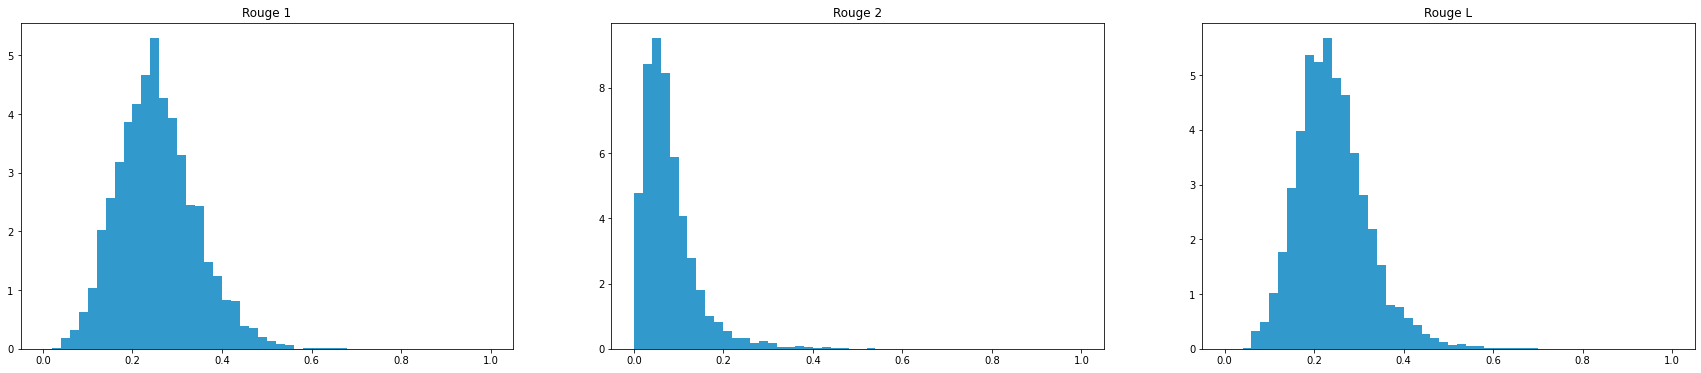

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(30,6))
ax1.set_title("Rouge 1")
ax2.set_title("Rouge 2")
ax3.set_title("Rouge L")
_ = ax1.hist(hist_1,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax2.hist(hist_2,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax3.hist(hist_l,bins=50,range=(0,1),density=True,color="#3299CC")

# finetunned dataset 3

## train finetunned

In [ ]:
import os
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src')

!python train.py -task ext -mode train -train_from '/content/drive/My Drive/tfm/dataset3/finetunned/model_step_20000.pt' -bert_data_path '/content/drive/My Drive/tfm/dataset3/bert_data/train/news' -ext_dropout 0.1 -model_path '/content/drive/My Drive/tfm/dataset3/finetunned' -lr 2e-3 -visible_gpus 0 -report_every 100 -save_checkpoint_steps 2000 -batch_size 3000 -train_steps 36000 -accum_count 2 -log_file '/content/drive/My Drive/tfm/dataset3/logs/finetunned' -use_interval true -warmup_steps 4000 -max_pos 512 -temp_dir '/content/drive/My Drive/tfm/dataset3/temp'


## getting val summaries

In [ ]:
import os
import time
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src')

for i in range(26000,32001,2000):
    
    print(i)
    !date
    start = time.time()
    code =  "python train.py -task ext -mode test -model_path '/content/drive/My Drive/tfm/dataset3/finetunned/validation_cand/' -test_from '/content/drive/My Drive/tfm/dataset3/finetunned/model_step_"+str(i)+".pt' -batch_size 100 -test_batch_size 100 -bert_data_path '/content/drive/My Drive/tfm/dataset3/bert_data/val/news' -temp_dir '/content/drive/My Drive/tfm/dataset3/temp' -log_file '/content/drive/My Drive/tfm/dataset3/logs/validation_finetunned' -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 1000 -alpha 0.82 -min_length 50 -result_path '/content/drive/My Drive/tfm/dataset3/finetunned/validation_cand/'"
    os.system(code)
    print(time.time()-start)



## getting validation scores

In [ ]:
import os
from rouge import Rouge

rouge = Rouge()
os.chdir('/content/drive/My Drive/tfm/dataset3/finetunned/validation_cand')
scores_1 = []
scores_2 = []
scores_l = []
scores_sum = []
count_candidate=0
rouge = Rouge()
for j in range(20000,32001,2000):
    print(j)
    gold = './_step'+str(j)+'.gold'
    candidate = './_step'+str(j)+'.candidate'
    with open(gold,'r') as s:
        summary = s.readlines()

    with open(candidate,'r') as s:
        cand = s.readlines()

    
    rouge_1= 0
    rouge_2= 0
    rouge_l= 0
    for i in range(len(summary)):
        count_candidate+=len(cand[i])
        scores = rouge.get_scores(cand[i],summary[i])
        rouge_1+=float(scores[0]['rouge-1']['f'])
        rouge_2+=float(scores[0]['rouge-2']['f'])
        rouge_l+=float(scores[0]['rouge-l']['f'])
        
    scores_1.append(rouge_1/len(summary))
    scores_2.append(rouge_2/len(summary))
    scores_l.append(rouge_l/len(summary))
    scores_sum.append(rouge_1/len(summary)+ rouge_2/len(summary)+rouge_l/len(summary))



In [ ]:
print("Biggest rouge-1 score: ",scores_1.index(max(scores_1)))
print("Biggest rouge-2 score: ",scores_2.index(max(scores_2)))
print("Biggest rouge-l score: ",scores_l.index(max(scores_l)))
print("Biggest sum rouge scores: ",scores_sum.index(max(scores_sum)))

Biggest rouge-1 score:  0
Biggest rouge-2 score:  0
Biggest rouge-l score:  0
Biggest sum rouge scores:  0


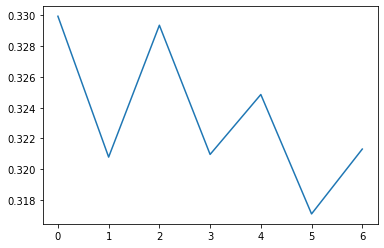

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(scores_1,label = 'rouge-1')

## test

In [ ]:
import os
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src')
   
!python train.py -task ext -mode test -model_path '/content/drive/My Drive/tfm/dataset3/finetunned/' -test_from '/content/drive/My Drive/tfm/dataset3/finetunned/model_step_20000.pt' -batch_size 3000 -test_batch_size 500 -bert_data_path '/content/drive/My Drive/tfm/dataset3/bert_data/test/news' -temp_dir '/content/drive/My Drive/tfm/dataset3/temp' -log_file '/content/drive/My Drive/tfm/dataset3/logs/test_finetunned' -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 1000 -alpha 0.1 -min_length 250 -result_path '/content/drive/My Drive/tfm/dataset3/finetunned/test_results'



In [ ]:
import os
from rouge import Rouge
import numpy as np


rouge = Rouge()
os.chdir('/content/drive/My Drive/tfm/dataset3/finetunned')
scores_1 = []
scores_2 = []
scores_l = []
hist_1 = []
hist_2 = []
hist_l = []

rouge = Rouge()
for j in [20000]:
    gold = './test_results_step'+str(j)+'.gold'
    candidate = './test_results_step'+str(j)+'.candidate'
    with open(gold,'r') as s:
        summary = s.readlines()
    
    with open(candidate,'r') as s:
        cand = s.readlines()

    rouge_1= 0
    rouge_2= 0
    rouge_l= 0
    for i in range(len(summary)):
       
        scores = rouge.get_scores(cand[i],summary[i])
        hist_1.append(float(scores[0]['rouge-1']['f']))
        hist_2.append(float(scores[0]['rouge-2']['f']))
        hist_l.append(float(scores[0]['rouge-l']['f']))

        rouge_1+=float(scores[0]['rouge-1']['f'])
        rouge_2+=float(scores[0]['rouge-2']['f'])
        rouge_l+=float(scores[0]['rouge-l']['f'])
    
    scores_1.append(rouge_1/len(summary))
    scores_2.append(rouge_2/len(summary))
    scores_l.append(rouge_l/len(summary))

def get_conf_int(hist,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(hist, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(hist, p))
    return lower,upper


alpha = 0.9
lower1,upper1 = get_conf_int(hist_1,alpha)
lower2,upper2 = get_conf_int(hist_2,alpha)
lower3,upper3 = get_conf_int(hist_l,alpha)

print('Rouge-1:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_1[0],alpha*100, lower1, upper1))
print('Rouge-2:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_2[0],alpha*100, lower2, upper2))
print('Rouge-l:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_l[0],alpha*100, lower3, upper3))
    



Rouge-1:
 	 mean: 0.3302 
 	 Confidence interval: 90 %  [0.195 , 0.486]
Rouge-2:
 	 mean: 0.1191 
 	 Confidence interval: 90 %  [0.022 , 0.294]
Rouge-l:
 	 mean: 0.2913 
 	 Confidence interval: 90 %  [0.158 , 0.462]


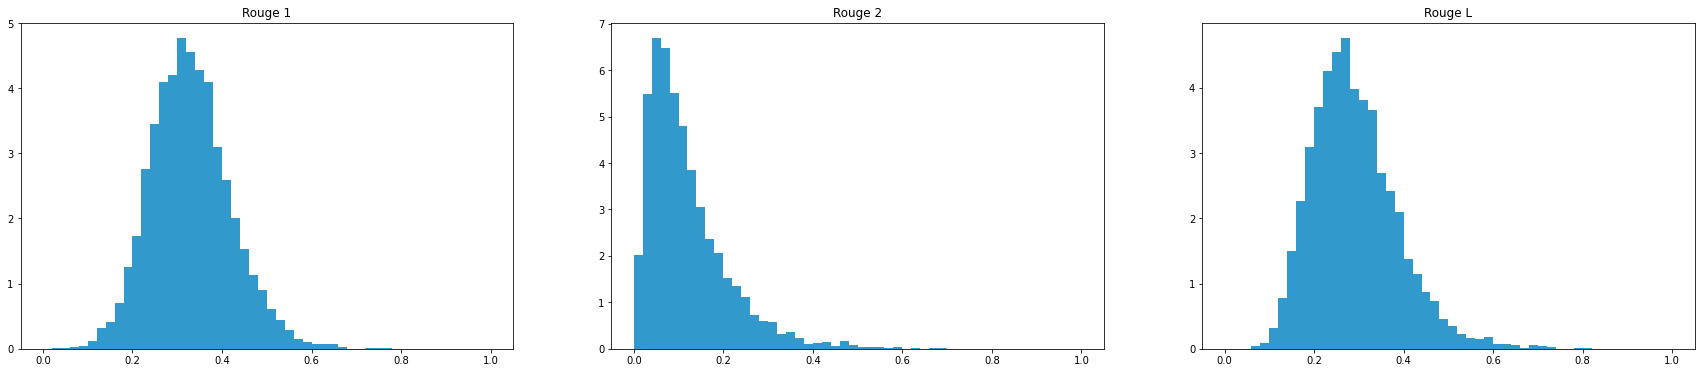

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(30,6))
ax1.set_title("Rouge 1")
ax2.set_title("Rouge 2")
ax3.set_title("Rouge L")
_ = ax1.hist(hist_1,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax2.hist(hist_2,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax3.hist(hist_l,bins=50,range=(0,1),density=True,color="#3299CC")

# dataset 2 pretrained model

In [ ]:
import os
os.chdir('/content/drive/My Drive/tfm/PreSumm-master/src')
   
!python train.py -task ext -mode test -model_path '/content/drive/My Drive/tfm/dataset2/pretrained/test/' -test_from '/content/drive/My Drive/tfm/dataset2/pretrained/bertext_cnndm_transformer.pt' -batch_size 3000 -test_batch_size 500 -bert_data_path '/content/drive/My Drive/tfm/dataset2/bert_data/test/news' -temp_dir '/content/drive/My Drive/tfm/dataset2/temp' -log_file '/content/drive/My Drive/tfm/dataset2/logs/pretrained' -sep_optim true -use_interval true -visible_gpus 0 -max_pos 512 -max_length 200 -alpha 0.9 -min_length 10 -result_path '/content/drive/My Drive/tfm/dataset2/pretrained/test/test_results'



In [ ]:
import os
from rouge import Rouge
import numpy as np


rouge = Rouge()
os.chdir('/content/drive/My Drive/tfm/dataset2/pretrained/test')
scores_1 = []
scores_2 = []
scores_l = []
hist_1 = []
hist_2 = []
hist_l = []

rouge = Rouge()
for j in [0]:
    gold = './test_results_step'+str(j)+'.gold'
    candidate = './test_results_step'+str(j)+'.candidate'
    with open(gold,'r') as s:
        summary = s.readlines()
    
    with open(candidate,'r') as s:
        cand = s.readlines()

    rouge_1= 0
    rouge_2= 0
    rouge_l= 0
    for i in range(len(summary)):
       
        scores = rouge.get_scores(cand[i],summary[i])
        hist_1.append(float(scores[0]['rouge-1']['f']))
        hist_2.append(float(scores[0]['rouge-2']['f']))
        hist_l.append(float(scores[0]['rouge-l']['f']))

        rouge_1+=float(scores[0]['rouge-1']['f'])
        rouge_2+=float(scores[0]['rouge-2']['f'])
        rouge_l+=float(scores[0]['rouge-l']['f'])
    
    scores_1.append(rouge_1/len(summary))
    scores_2.append(rouge_2/len(summary))
    scores_l.append(rouge_l/len(summary))

def get_conf_int(hist,alpha):
    # confidence intervals
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(hist, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(hist, p))
    return lower,upper


alpha = 0.9
lower1,upper1 = get_conf_int(hist_1,alpha)
lower2,upper2 = get_conf_int(hist_2,alpha)
lower3,upper3 = get_conf_int(hist_l,alpha)

print('Rouge-1:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_1[0],alpha*100, lower1, upper1))
print('Rouge-2:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_2[0],alpha*100, lower2, upper2))
print('Rouge-l:\n \t mean: %.4f \n \t Confidence interval: %d %%  [%.3f , %.3f]' % (scores_l[0],alpha*100, lower3, upper3))
    



Rouge-1:
 	 mean: 0.4143 
 	 Confidence interval: 90 %  [0.237 , 0.605]
Rouge-2:
 	 mean: 0.1843 
 	 Confidence interval: 90 %  [0.036 , 0.404]
Rouge-l:
 	 mean: 0.4007 
 	 Confidence interval: 90 %  [0.222 , 0.610]


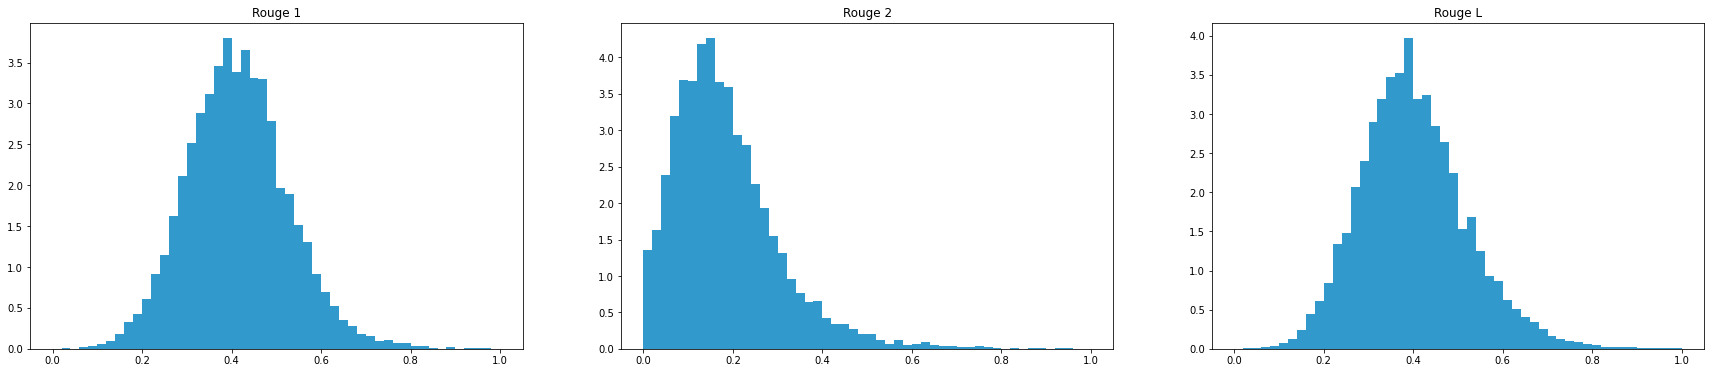

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(30,6))
ax1.set_title("Rouge 1")
ax2.set_title("Rouge 2")
ax3.set_title("Rouge L")
_ = ax1.hist(hist_1,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax2.hist(hist_2,bins=50,range=(0,1),density=True,color="#3299CC")
_ = ax3.hist(hist_l,bins=50,range=(0,1),density=True,color="#3299CC")